# Setup

## Connect Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/badminton/

/content/gdrive/MyDrive/badminton


## Install packages
tensorflow >2.4

In [3]:
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd 
import numpy as np
import imageio
import cv2
import os

In [4]:
!unzip input_features/domain.zip -d input_features/

Archive:  input_features/domain.zip
   creating: input_features/domain/
   creating: input_features/domain/domain_pro/
   creating: input_features/domain/domain_pro/match1/
  inflating: input_features/domain/domain_pro/match1/1_06_08_x.csv  
  inflating: input_features/domain/domain_pro/match1/1_06_08_y.csv  
  inflating: input_features/domain/domain_pro/match1/1_03_05_x.csv  
  inflating: input_features/domain/domain_pro/match1/1_03_05_y.csv  
  inflating: input_features/domain/domain_pro/match1/1_03_06_x.csv  
  inflating: input_features/domain/domain_pro/match1/1_03_06_y.csv  
  inflating: input_features/domain/domain_pro/match1/1_01_00_x.csv  
  inflating: input_features/domain/domain_pro/match1/1_01_00_y.csv  
  inflating: input_features/domain/domain_pro/match1/1_02_01_x.csv  
  inflating: input_features/domain/domain_pro/match1/1_02_01_y.csv  
  inflating: input_features/domain/domain_pro/match1/1_03_04_x.csv  
  inflating: input_features/domain/domain_pro/match1/1_03_04_y.csv  

## Define hyperparameters

In [158]:
dataset_rootdir = '/content/gdrive/MyDrive/badminton/input_features/domain/domain_pro/'
class_vocab = ['nohit','hit_near','hit_far']

MAX_SEQ_LENGTH = 14
NUM_RELAX = 6
PRED_MID = False
WIN_OVERLAP = 0.75
N_CLASSES = 3

possible_feats = ['playerpos', 'pose', 'shuttle', 'shuttlepose', 'courtshuttlepose'] #shuttlepose the best
feat_idx = 3
ADD_NOISE = False

crt_w = 607 # court model params for computing homography
crt_h = 1341

NUM_RNN_LAYERS = 2
NUM_RNN_UNITS = 32
RNN_TYPE = 'GRU'
EMBEDDING_LAYER = True

BATCH_SIZE = 256
EPOCHS = 150
VALIDATION = 0.25



In [159]:
INPUT_FEATS = possible_feats[feat_idx]
dict_feats_dim = {possible_feats[0]: 8, possible_feats[1]: 68, possible_feats[2]:2, possible_feats[3]: 70, possible_feats[4]: 78}
NUM_FEATURES = dict_feats_dim[INPUT_FEATS]

In [160]:
weights_dir = os.path.join('/content/gdrive/MyDrive/badminton/mm_weights/', INPUT_FEATS)
if not os.path.exists(weights_dir):
  os.makedirs(weights_dir)
weights_path = os.path.join(weights_dir, str(EPOCHS))

# Data preparation

Preprocess dataset into format suitable for feeding into RNN
- batch consecutive frames (from same video) into sequences of 12 (maybe adjust later) with 75% overlap, each sequence is given a hit label if last 6 frames contain a hit
- class-imbalance: randomly select eq number of non-hit sequences for training/testing
- scale coordinates to [1,2], undetected set to (0,0), don't use normalisation (maybe adjust later)
- Add artificial noise: for 20% of the sequences - drop 15% pose, 30% shuttles, no court (maybe don't do this)

## Functions for data processing

In [161]:
# function to get list of list csvpaths
def get_csvpaths(dataset_rootdir='input_features/domain_pro/', is_train=True, is_x=True):
    subdir = 'train/' if is_train else 'test/'
    endname = '_x' if is_x else '_y'
        
    dir_allmatch = dataset_rootdir + subdir
    match_dirs = [dir_allmatch + matchdir for matchdir in sorted(os.listdir(dir_allmatch))]

    csvpaths = []
    for matchdir in match_dirs:
      csvdir = matchdir + '/'
      csv_dirs = [csvdir + csv for csv in sorted(os.listdir(csvdir)) if endname in csv]
      csvpaths.append(csv_dirs)
    
    return csvpaths

#### Batch consecutive frames (from same video) into sequences of 12 (maybe adjust later) with 75% overlap, each sequence is given a hit label if last 6 frames contain a hit

In [162]:
# batching functions
def get_crt_transf_matrix(crt_pts): # transform pixels to coordinates in court model
    crt_pts = crt_pts.astype('float32')
    model_pts = np.array([[0, 0], [crt_w-1, 0], [crt_w-1, crt_h-1], [0, crt_h-1]]).astype('float32')
    M = cv2.getPerspectiveTransform(crt_pts, model_pts)
    return M

def transform_coordinates(coordinates, M):
    coordinates = np.array([coordinates[0], coordinates[1], 1])
    transformed = M.dot(coordinates)
    transformed = transformed / transformed[2]
    return (int(transformed[0]), int(transformed[1]))

def get_feet_cols():
    feet_cols = []
    for player in ['near', 'far']:
      for p in range(15,17):
        feet_cols.append(player + '_pose' + str(p) + '_x')
        feet_cols.append(player + '_pose' + str(p) + '_y')
    return feet_cols

def get_pose_cols():
    pose_cols = []
    for player in ['near', 'far']:
      for p in range(17):
        pose_cols.append(player + '_pose' + str(p) + '_x')
        pose_cols.append(player + '_pose' + str(p) + '_y')
    return pose_cols

def get_shuttle_cols():
    shuttle_cols = ['ball_x', 'ball_y']
    return shuttle_cols

def get_court_cols():
    court_cols = ["tl_x","tl_y","tr_x","tr_y","br_x","br_y","bl_x","bl_y"]
    return court_cols


def window(a, winlen = MAX_SEQ_LENGTH, stepsize = int((1-WIN_OVERLAP)*MAX_SEQ_LENGTH)):
    sub_windows = (
        np.expand_dims(np.arange(winlen), 0) +
        np.expand_dims(np.arange(a.shape[0] + 1 - winlen), 0).T
    )
    
    # Fancy indexing to select every V rows.
    return a[sub_windows[::stepsize]]

def load_X(X_path, winlen = MAX_SEQ_LENGTH, stepsize = int((1-WIN_OVERLAP)*MAX_SEQ_LENGTH)):
    df =  pd.read_csv(X_path) #, index_col=0)
    
    if INPUT_FEATS == possible_feats[0]: # playerpos
      crt_cols = get_court_cols()
      df_tmp = pd.DataFrame(df, columns=crt_cols)
      crt = df_tmp.head(1).to_numpy()[0].reshape((4,2))
      M = get_crt_transf_matrix(crt)

      feet_cols = get_feet_cols()
      df = pd.DataFrame(df, columns=feet_cols)
      array_coords_leftrightfoot = df.to_numpy().reshape((len(df), 8))

      array_feats = np.zeros((len(df), 8))
      for r, row in enumerate(array_coords_leftrightfoot):
          for i in range(4):
            coords = (row[2*i], row[2*i+1])
            x, y = transform_coordinates(coords, M)
            array_feats[r, 2*i] = x
            array_feats[r, 2*i+1] = y
    
    elif INPUT_FEATS == possible_feats[1]: # pose
      cols = get_pose_cols()
      df = pd.DataFrame(df, columns=cols)
    elif INPUT_FEATS == possible_feats[2]: # shuttle
      cols = get_shuttle_cols()
      df = pd.DataFrame(df, columns=cols)
    elif INPUT_FEATS == possible_feats[3]: # shuttle + pose
      shuttle_cols = get_shuttle_cols()
      pose_cols = get_pose_cols()
      cols = shuttle_cols + pose_cols
      df = pd.DataFrame(df, columns=cols)
    elif INPUT_FEATS == possible_feats[4]: # shuttle + pose + court
      crt_cols = get_court_cols()
      shuttle_cols = get_shuttle_cols()
      pose_cols = get_pose_cols()
      cols = crt_cols + shuttle_cols + pose_cols
      df = pd.DataFrame(df, columns=cols)
      
    array_feats = df.to_numpy()
    
    return(window(array_feats, winlen=winlen, stepsize=stepsize))

def load_Y(Y_path , winlen = MAX_SEQ_LENGTH, stepsize = int((1-WIN_OVERLAP)*MAX_SEQ_LENGTH)):
    df =  pd.read_csv(Y_path)
    array_labels = df['player_hit'].to_numpy()
    
    windowed_array = window(array_labels, winlen=winlen, stepsize=stepsize)

    if not PRED_MID:
      start_i = MAX_SEQ_LENGTH - NUM_RELAX
      labels = [1 if 1 in row[start_i:] else 2 if 2 in row[start_i:] else 0 for row in windowed_array ]
    else:
      start_i = (MAX_SEQ_LENGTH - NUM_RELAX)//2
      end_i = start_i + NUM_RELAX
      labels = [1 if 1 in row[start_i: end_i] else 2 if 2 in row[start_i: end_i] else 0 for row in windowed_array ]
    
    return(np.array(labels))

def batch_all_data(csv_xpaths, csv_ypaths):
    all_X = np.array([]).reshape((0, MAX_SEQ_LENGTH, NUM_FEATURES))
    all_Y = np.array([]).reshape((0, ))

    num_matches = len(csv_xpaths)
    for i in range(num_matches):
        for j in range(len(csv_xpaths[i])):
            batched_X = load_X(csv_xpaths[i][j])
            all_X = np.concatenate((all_X, batched_X))

            labels = load_Y(csv_ypaths[i][j])
            all_Y = np.concatenate((all_Y, labels))
    return(all_X, all_Y)

#### Class imbalance: Randomly select non-hit sequences so that hit1-hit2-hit0 labels are roughly balanced

In [163]:
np.random.seed(0)

def balance_dataset(all_X, all_Y):
    hit1  = np.count_nonzero(all_Y == 1)
    hit2  = np.count_nonzero(all_Y == 2)
    hit0  = np.count_nonzero(all_Y == 0)
    num_hit0_toretain = (hit1 + hit2)//2 # see if higher number of nohits lead to better precision
    
    ind_nohit = np.where(all_Y == 0)[0]
    np.random.shuffle(ind_nohit)
    selected_nohit = ind_nohit[:num_hit0_toretain]
    hits = np.where(all_Y != 0)[0]
    ind_toretain = np.concatenate((hits, selected_nohit))
    
    return all_X[ind_toretain], all_Y[ind_toretain]

#### Data preprocessing: 
- Scale data to [1,2] while undetected points remain set at (0,0)
- Add artificial noise: for 20% of the sequences - drop 15% pose, 30% shuttles, no court (see if it works lor)

indices:
- 0-7: crt
- 8-9: shuttle
- 10-43: pose1
- 44-77: pose2

In [164]:
def scale_Xdata(all_X, x_mean=0.49056, x_std=0.11212, y_mean=0.57050, y_std=0.16662):
    '''
    numfeats = all_X.shape[2]
    x_coord_cols = np.arange(0,int(numfeats/2),2)
    y_coord_cols = np.arange(1,int(numfeats/2),2)
    # normalise detected coordinates by subtracting mean and dividing by sd
    x_coord_vals = all_X[:,:,x_coord_cols]
    x_coord_vals[x_coord_vals != 0] -= x_mean
    x_coord_vals[x_coord_vals != 0]/= x_std
    
    y_coord_vals = all_X[:,:,y_coord_cols]
    y_coord_vals[y_coord_vals != 0] -= y_mean
    y_coord_vals[y_coord_vals != 0]/= y_std
    
    all_X[:,:,x_coord_cols] = x_coord_vals
    all_X[:,:,y_coord_cols] = y_coord_vals
    
    # scale detected coordinates from 0-1 to 1-2, undetected remains at (0,0)
    all_X[all_X != 0] += 1
    '''
    return all_X
    
def addnoise_Xdata(all_X, fraction_noise=0.2, fraction_posedrop=0.15, fraction_shuttledrop=0.3):
    # add artificial noise
    num_posedrop_perseq = int(fraction_posedrop*MAX_SEQ_LENGTH) # drop the far player
    num_shuttledrop_perseq = int(fraction_shuttledrop*MAX_SEQ_LENGTH)

    pose_zeros = np.zeros(34)
    shuttle_zeros = np.zeros(2)
    court_zeros = np.zeros(8)

    num_seq = all_X.shape[0]
    ind_seq = np.arange(num_seq)
    np.random.shuffle(ind_seq)
    num_addnoise = int(num_seq*fraction_noise)
    ind_addnoise = ind_seq[0:num_addnoise]

    for i in ind_addnoise:
        ind_el = np.arange(MAX_SEQ_LENGTH)
        np.random.shuffle(ind_el)
        ind_posedrop = ind_el[:num_posedrop_perseq]

        np.random.shuffle(ind_el)
        ind_shuttledrop = ind_el[:num_shuttledrop_perseq]

        for j in range(MAX_SEQ_LENGTH):
            all_X[i, j, 0:8] = court_zeros

        for j in ind_posedrop:
            all_X[i, j, 44:] = pose_zeros

        for j in ind_shuttledrop:
            all_X[i, j, 8:10] = shuttle_zeros
            
    return all_X

In [165]:
# Overall pipeline

def prepare_data(root_dir='mmfeats_prodataset/', fraction_noise=0.2, fraction_posedrop=0.15, fraction_shuttledrop=0.3):

    ## get csvpaths
    # TRAIN
    train_csv_xpaths = get_csvpaths(dataset_rootdir=root_dir, is_train=True, is_x=True)
    train_csv_ypaths = get_csvpaths(dataset_rootdir=root_dir, is_train=True, is_x=False)
    # TEST
    test_csv_xpaths = get_csvpaths(dataset_rootdir=root_dir, is_train=False, is_x=True)
    test_csv_ypaths = get_csvpaths(dataset_rootdir=root_dir, is_train=False, is_x=False)

    ## batch data and assign hit labels
    train_all_X, train_all_Y = batch_all_data(train_csv_xpaths, train_csv_ypaths)
    test_all_X, test_all_Y = batch_all_data(test_csv_xpaths, test_csv_ypaths)
    
    ## balance dataset
    train_X, train_Y = balance_dataset(train_all_X, train_all_Y)
    test_X, test_Y = balance_dataset(test_all_X, test_all_Y)
    
    ## preprocessing: scaling and adding noise
    train_X = scale_Xdata(train_X)
    if INPUT_FEATS == possible_feats[4] and ADD_NOISE:
      train_X = addnoise_Xdata(train_X, fraction_noise=0.2, fraction_posedrop=0.15, fraction_shuttledrop=0.3)

    test_X = scale_Xdata(test_X) # don't need add noise for test data
    
    return train_X, train_Y, test_X, test_Y

## Run the data prep functions

In [153]:
train_X, train_Y, test_X, test_Y = prepare_data(root_dir=dataset_rootdir, fraction_noise=0.2, fraction_posedrop=0.15, fraction_shuttledrop=0.3)
print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

(6652, 14, 78) (6652,) (1095, 14, 78) (1095,)


# The sequence model

Now, we can feed this data to a sequence model consisting of recurrent layers like `GRU`. 

In [33]:
# Utility for our sequence model.

def get_sequence_model(num_rnn_layers=2, num_rnn_units=32, rnn_type='GRU', embedding_layer=True): 
  features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
  if embedding_layer:
    x = keras.layers.Dense(32, activation="relu")(features_input)
  else:
    x = features_input
    
  if rnn_type=='GRU':
    for i in range(num_rnn_layers - 1):
      x = keras.layers.GRU(num_rnn_units, return_sequences=True)(x)
    x = keras.layers.GRU(num_rnn_units)(x)

  elif rnn_type=='LSTM':
    for i in range(num_rnn_layers - 1):
      x = keras.layers.LSTM(num_rnn_units, return_sequences=True, return_state=True)(x)
    x = keras.layers.LSTM(num_rnn_units)(x)
  else:
    print('No RNN used')
    
  x = keras.layers.Dropout(0.4)(x)
  output = keras.layers.Dense(N_CLASSES, activation="softmax")(x)
  
  rnn_model = keras.Model(features_input, output)
  rnn_model.compile(loss="sparse_categorical_crossentropy", 
        optimizer="adam",
        metrics=["accuracy"])
  
  return rnn_model


# Utility for running experiments.
def run_experiment(filepath = '/content/gdrive/MyDrive/badminton/mm_weights', num_rnn_layers=2, num_rnn_units=32, rnn_type='GRU', embedding_layer=True):
    
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_weights_only=True, 
                                 save_best_only=True, verbose=1)

    seq_model = get_sequence_model(num_rnn_layers=num_rnn_layers, num_rnn_units=num_rnn_units, rnn_type=rnn_type, embedding_layer=embedding_layer)
    history = seq_model.fit(train_X, train_Y,
        validation_split=VALIDATION,
        epochs=EPOCHS, 
        callbacks=[checkpoint])
    
    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate(test_X, test_Y)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model

# Run experiment

In [134]:
model = get_sequence_model(num_rnn_layers=NUM_RNN_LAYERS, num_rnn_units=NUM_RNN_UNITS, rnn_type=RNN_TYPE, embedding_layer=EMBEDDING_LAYER)
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 14, 78)]          0         
                                                                 
 dense_24 (Dense)            (None, 14, 32)            2528      
                                                                 
 gru_24 (GRU)                (None, 32)                6336      
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_25 (Dense)            (None, 3)                 99        
                                                                 
Total params: 8,963
Trainable params: 8,963
Non-trainable params: 0
_________________________________________________________________


In [154]:
_, sequence_model = run_experiment(filepath = weights_path, num_rnn_layers=NUM_RNN_LAYERS, num_rnn_units=NUM_RNN_UNITS, rnn_type=RNN_TYPE, embedding_layer=EMBEDDING_LAYER)

Epoch 1/150
147/156 [===========================>..] - ETA: 0s - loss: 0.9769 - accuracy: 0.4466
Epoch 1: val_loss improved from inf to 2.13007, saving model to /content/gdrive/MyDrive/badminton/mm_weights/courtshuttlepose_nonoise/150
156/156 [==============================] - 5s 16ms/step - loss: 0.9760 - accuracy: 0.4476 - val_loss: 2.1301 - val_accuracy: 0.0000e+00
Epoch 2/150
150/156 [===========================>..] - ETA: 0s - loss: 0.9492 - accuracy: 0.5092
Epoch 2: val_loss improved from 2.13007 to 1.86371, saving model to /content/gdrive/MyDrive/badminton/mm_weights/courtshuttlepose_nonoise/150
156/156 [==============================] - 1s 9ms/step - loss: 0.9518 - accuracy: 0.5107 - val_loss: 1.8637 - val_accuracy: 0.0000e+00
Epoch 3/150
156/156 [==============================] - ETA: 0s - loss: 0.8543 - accuracy: 0.6306
Epoch 3: val_loss did not improve from 1.86371
156/156 [==============================] - 1s 7ms/step - loss: 0.8543 - accuracy: 0.6306 - val_loss: 1.9310 - v

# Evaluation

### Evaluation

In [35]:
def Intersection(lst1, lst2):
  return list(set(lst1).intersection(lst2))

def Union(lst1, lst2):
  final_list = list(set().union(lst1, lst2))
  return final_list

def eval_metrics(test_Y, pred_label):
  '''
  only look at frames where hits occurred
  returns accuracy, recall, precision
  '''
  true_hit_set = [(i, label) for i, label in enumerate(test_Y) if label!=0] 
  pred_hit_set = [(i, label) for i, label in enumerate(pred_label) if label!=0] 

  acc = len(Intersection(true_hit_set, pred_hit_set)) / len(Union(true_hit_set, pred_hit_set))
  recall = len(Intersection(true_hit_set, pred_hit_set)) / len(true_hit_set)
  prec = len(Intersection(true_hit_set, pred_hit_set)) / len(pred_hit_set)
  f1 = 2*(prec*recall)/(prec+recall)

  return prec, recall, acc, f1

In [155]:
probabilities = sequence_model.predict(test_X)
pred_label = np.argmax(probabilities, axis=1)
prec, recall, acc, f1 = eval_metrics(test_Y, pred_label)
print(prec, recall, acc, f1)

35/35 [==============================] - 1s 3ms/step
0.8896457765667575 0.8945205479452055 0.8051787916152897 0.8920765027322405


### Plot confusion matrix

Seems like hit_1 is doing quite well, but hit_2 has low precision, often mistaking no hit for a hit at the far player.

In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90)
    plt.xlabel('Predicted Label', fontsize = 50)
    plt.ylabel('True Label', fontsize = 50)

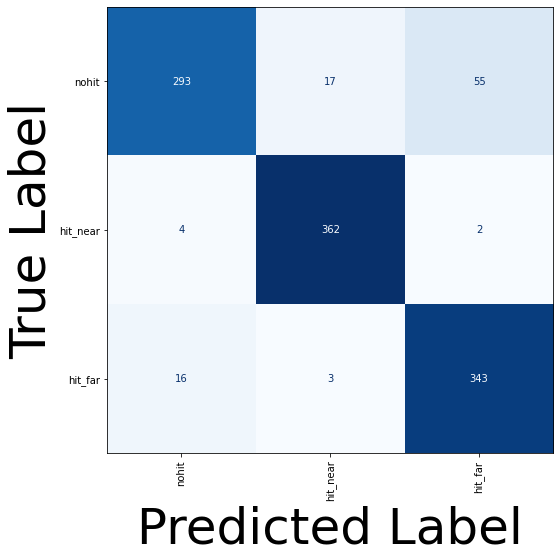

In [41]:
plot_confusion_matrix(test_Y, pred_label, class_vocab)

## Evaluation on am dataset

In [65]:
# load model from check point
sequence_model = get_sequence_model(num_rnn_layers=NUM_RNN_LAYERS, num_rnn_units=NUM_RNN_UNITS, rnn_type=RNN_TYPE, embedding_layer=EMBEDDING_LAYER)
sequence_model.load_weights(weights_path)

In [156]:
am_dir = 'input_features/domain/domain_am_singles/'
test_csv_xpaths_am = get_csvpaths(dataset_rootdir=am_dir, is_train=False, is_x=True)
test_csv_ypaths_am = get_csvpaths(dataset_rootdir=am_dir, is_train=False, is_x=False)
test_all_X_am, test_all_Y_am = batch_all_data(test_csv_xpaths_am, test_csv_ypaths_am)
test_X_am, test_Y_am = balance_dataset(test_all_X_am, test_all_Y_am)
test_X_am = scale_Xdata(test_X_am)

print(test_X_am.shape, test_Y_am.shape)

(969, 14, 78) (969,)


In [157]:
probabilities = sequence_model.predict(test_X_am)
pred_label = np.argmax(probabilities, axis=1)
prec, recall, acc, f1 = eval_metrics(test_Y_am, pred_label)
print(prec, recall, acc, f1)

31/31 [==============================] - 0s 3ms/step
0.5464566929133858 0.5371517027863777 0.3715203426124197 0.5417642466822795


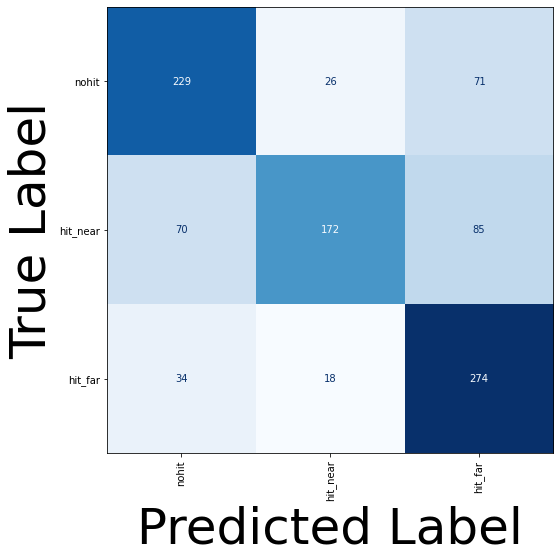

In [47]:
plot_confusion_matrix(test_Y_am, pred_label, class_vocab)

# Inference on video

In [166]:
def sequence_prediction(framefeats, print=False):
  probabilities = sequence_model.predict(framefeats)
  pred_class = np.argmax(probabilities[0])

  return pred_class, probabilities[0]

def csv_prediction(path):
  all_framefeats = load_X(path, winlen = MAX_SEQ_LENGTH, stepsize = 1)
  all_framefeats = scale_Xdata(all_framefeats)
  probs = sequence_model.predict(all_framefeats)
  predictions = np.argmax(probs, axis=1)
  
  return predictions, probs


def vis_pred_onvideo(vidpath, outvidpath, predictions):
  cap = cv2.VideoCapture(vidpath)
  width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))   # float `width`
  height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # float `height`
  fps = int(cap.get(cv2.CAP_PROP_FPS))
  output = cv2.VideoWriter(outvidpath, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

  framenum = 0
  while(True):
    ret, frame = cap.read()
    if(ret):
      if framenum > 6 and framenum - 6 < len(predictions): # because of batching into seq of 12, predictions will be shorter than total frame num
        curr_pred = predictions[framenum-6]
      else: curr_pred = 0
      
      if curr_pred == 1:
        frame[:,:,0] = 255 # frame turns blue
      elif curr_pred == 2:
        frame[:,:,2] = 255 # frame turns red

      # writing the new frame in output
      output.write(frame)
      framenum += 1
    else:
      break
  
  output.release()
  cap.release()

## Inference: load checkpoint, load input video, and visualise

In [167]:
# load model from check point
sequence_model = get_sequence_model(num_rnn_layers=NUM_RNN_LAYERS, num_rnn_units=NUM_RNN_UNITS, rnn_type=RNN_TYPE, embedding_layer=EMBEDDING_LAYER)
sequence_model.load_weights(weights_path)

In [168]:
dataset_rootdir = 'input_features/domain/domain_pro/'
out_rootdir = 'domain_probs/pro/'
for traindir in os.listdir(dataset_rootdir):
  for matchdir in sorted(os.listdir(os.path.join(dataset_rootdir, traindir))):
    for domaincsv in sorted(os.listdir(os.path.join(dataset_rootdir, traindir, matchdir))):
      if domaincsv.endswith('x.csv'):
        basename = domaincsv.split('_x.csv')[0]
        csv_file = os.path.join(dataset_rootdir, traindir, matchdir, domaincsv)
    
        outdir = os.path.join(out_rootdir, matchdir)
        if not os.path.exists(outdir):
          os.makedirs(outdir)
        
        outpath = os.path.join(outdir, basename + '_probs.npy')
        print(outpath)

        preds, probs = csv_prediction(csv_file)

        np.save(outpath, np.array(probs))

domain_probs/pro/match1/1_01_00_probs.npy
20/20 [==============================] - 1s 3ms/step
domain_probs/pro/match1/1_02_00_probs.npy
16/16 [==============================] - 0s 3ms/step
domain_probs/pro/match1/1_02_01_probs.npy
6/6 [==============================] - 0s 4ms/step
domain_probs/pro/match1/1_02_02_probs.npy
8/8 [==============================] - 0s 3ms/step
domain_probs/pro/match1/1_02_03_probs.npy
3/3 [==============================] - 0s 5ms/step
domain_probs/pro/match1/1_02_04_probs.npy
5/5 [==============================] - 0s 4ms/step
domain_probs/pro/match1/1_03_04_probs.npy
4/4 [==============================] - 0s 4ms/step
domain_probs/pro/match1/1_03_05_probs.npy
11/11 [==============================] - 0s 3ms/step
domain_probs/pro/match1/1_03_06_probs.npy
8/8 [==============================] - 0s 3ms/step
domain_probs/pro/match1/1_06_06_probs.npy
5/5 [==============================] - 0s 3ms/step
domain_probs/pro/match1/1_06_08_probs.npy
3/3 [=================

In [169]:
dataset_rootdir = 'input_features/domain/domain_am_singles/test/'
out_rootdir = 'domain_probs/am_singles/'
for matchdir in sorted(os.listdir(dataset_rootdir)):
  for domaincsv in sorted(os.listdir(os.path.join(dataset_rootdir, matchdir))):
    if domaincsv.endswith('x.csv'):
      basename = domaincsv.split('_x.csv')[0]
      csv_file = os.path.join(dataset_rootdir, matchdir, domaincsv)
  
      outdir = os.path.join(out_rootdir, matchdir)
      if not os.path.exists(outdir):
        os.makedirs(outdir)
      
      outpath = os.path.join(outdir, basename + '_probs.npy')
      print(outpath)

      preds, probs = csv_prediction(csv_file)

      np.save(outpath, np.array(probs))

domain_probs/am_singles/match24/1_00_01_probs.npy
6/6 [==============================] - 0s 3ms/step
domain_probs/am_singles/match24/1_01_01_probs.npy
6/6 [==============================] - 0s 3ms/step
domain_probs/am_singles/match24/1_01_02_probs.npy
14/14 [==============================] - 0s 5ms/step
domain_probs/am_singles/match24/1_01_03_probs.npy
10/10 [==============================] - 0s 3ms/step
domain_probs/am_singles/match24/1_01_04_probs.npy
8/8 [==============================] - 0s 3ms/step
domain_probs/am_singles/match24/1_02_04_probs.npy
22/22 [==============================] - 0s 3ms/step
domain_probs/am_singles/match24/1_03_04_probs.npy
4/4 [==============================] - 0s 4ms/step
domain_probs/am_singles/match24/1_03_05_probs.npy
23/23 [==============================] - 0s 3ms/step
domain_probs/am_singles/match24/1_04_05_probs.npy
3/3 [==============================] - 0s 5ms/step
domain_probs/am_singles/match24/1_05_05_probs.npy
5/5 [============================

In [170]:
dataset_rootdir = 'input_features/domain/domain_am_doubles/'
out_rootdir = 'domain_probs/am_doubles/'
for matchdir in sorted(os.listdir(dataset_rootdir)):
  for pairdir in sorted(os.listdir(os.path.join(dataset_rootdir, matchdir))):
    for domaincsv in sorted(os.listdir(os.path.join(dataset_rootdir, matchdir, pairdir))): 
      if domaincsv.endswith('x.csv'):
        basename = domaincsv.split('_x.csv')[0]
        csv_file = os.path.join(dataset_rootdir, matchdir, pairdir, domaincsv)
    
        outdir = os.path.join(out_rootdir, matchdir)
        if not os.path.exists(outdir):
          os.makedirs(outdir)
        
        outpath = os.path.join(outdir, basename + '_' + pairdir + '_probs.npy')
        print(outpath)

        preds, probs = csv_prediction(csv_file)

        np.save(outpath, np.array(probs))

domain_probs/am_doubles/match_china/doubles0_pair1_probs.npy
10/10 [==============================] - 0s 5ms/step
domain_probs/am_doubles/match_china/doubles1_pair1_probs.npy
11/11 [==============================] - 0s 3ms/step
domain_probs/am_doubles/match_china/doubles2_pair1_probs.npy
11/11 [==============================] - 0s 3ms/step
domain_probs/am_doubles/match_china/doubles3_pair1_probs.npy
10/10 [==============================] - 0s 3ms/step
domain_probs/am_doubles/match_china/doubles0_pair2_probs.npy
10/10 [==============================] - 0s 3ms/step
domain_probs/am_doubles/match_china/doubles1_pair2_probs.npy
11/11 [==============================] - 0s 3ms/step
domain_probs/am_doubles/match_china/doubles2_pair2_probs.npy
11/11 [==============================] - 0s 3ms/step
domain_probs/am_doubles/match_china/doubles3_pair2_probs.npy
10/10 [==============================] - 0s 3ms/step
domain_probs/am_doubles/match_clementi/doubles0_pair1_probs.npy
11/11 [=================

In [171]:
!zip -r domain_probs.zip domain_probs

  adding: domain_probs/ (stored 0%)
  adding: domain_probs/pro/ (stored 0%)
  adding: domain_probs/pro/match1/ (stored 0%)
  adding: domain_probs/pro/match1/1_01_00_probs.npy (deflated 8%)
  adding: domain_probs/pro/match1/1_02_00_probs.npy (deflated 8%)
  adding: domain_probs/pro/match1/1_02_01_probs.npy (deflated 7%)
  adding: domain_probs/pro/match1/1_02_02_probs.npy (deflated 8%)
  adding: domain_probs/pro/match1/1_02_03_probs.npy (deflated 6%)
  adding: domain_probs/pro/match1/1_02_04_probs.npy (deflated 7%)
  adding: domain_probs/pro/match1/1_03_04_probs.npy (deflated 8%)
  adding: domain_probs/pro/match1/1_03_05_probs.npy (deflated 8%)
  adding: domain_probs/pro/match1/1_03_06_probs.npy (deflated 7%)
  adding: domain_probs/pro/match1/1_06_06_probs.npy (deflated 7%)
  adding: domain_probs/pro/match1/1_06_08_probs.npy (deflated 7%)
  adding: domain_probs/pro/match1/1_06_09_probs.npy (deflated 8%)
  adding: domain_probs/pro/match10/ (stored 0%)
  adding: domain_probs/pro/match10/1_

#### visualise on video

In [ ]:
# visualise predictions on video
vid_testpath = '/content/gdrive/MyDrive/badminton/difficult_dataset/match_china2/rally_video/singles0.mp4'
outvidpath = '/content/gdrive/MyDrive/badminton/china2_singles0_mmarch2.mp4'
vis_pred_onvideo(vid_testpath, outvidpath, predictions)